In [1]:
import os
import numpy as np  
import matplotlib.pyplot as plt

In [2]:
seed = 7
np.random.seed(seed)

In [3]:
import keras
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import KFold

In [4]:
model_path_cnn = 'C:/Users/singhegm/Downloads/Fashion-mnist-cnn-keras-master/Fashion-mnist-cnn-keras-master/fm_cnn_model.h5'

In [5]:
import math as mt

def average(numbers):
    """
    Return the sample arithmetic mean of data.
    :param numbers: a list of float
    :return:
    """
    try:
        return float(sum(numbers)) / max(len(numbers), 1)
    except ZeroDivisionError:
        return 0

In [6]:
def sum_of_square_deviation(numbers, mean):
    """
    Return sum of square deviations of sequence data.
    :param numbers: a list of float
    :param mean:
    :return:
    """
    try:
        return float(1 / len(numbers) * sum((x - mean) ** 2 for x in numbers))
    except ZeroDivisionError:
        return 0

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D

from keras.optimizers import SGD
from keras.constraints import maxnorm

def model_cnn(num_classes):
    # create model
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Layer 2
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Layer 3
    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # Layer 4
    model.add(Flatten())

    # Layer 5
    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    
    # Layer 6
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    lrate = 0.01
    decay = lrate / epochs
    
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [8]:
batch_size = 256
epochs = 15

n_splits = 5

from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
            EarlyStopping( monitor='val_acc', patience=10, mode='max', verbose=1),
            ModelCheckpoint(model_path_cnn, monitor='val_acc', save_best_only=True, mode='max', verbose=0)
            ]

In [9]:
def main():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    print('train shape: {}'.format(x_train.shape))
    print('test shape: {}'.format(x_test.shape))
    
    unique, counts = np.unique(y_train, return_counts=True)
    print(dict(zip(unique, counts)))

    y_train_CNN = y_train  # only labels i.e targets digits
    X_train_CNN = x_train.reshape(x_train.shape[0], 1, 28, 28).astype(np.uint8)
    print('train shape after reshape: {}'.format(X_train_CNN.shape))

    y_test_CNN = y_test  # only labels i.e targets digits
    X_test_CNN = x_test.reshape(x_test.shape[0], 1, 28, 28).astype(np.uint8)
    print('test shape after reshape: {}'.format(X_test_CNN.shape))

    # normalize inputs from 0-255 to 0-1
    X_train_CNN = X_train_CNN / 255
    X_test_CNN = X_test_CNN / 255

    # one hot encode outputs
    y_train_CNN = to_categorical(y_train_CNN)
    y_test_CNN = to_categorical(y_test_CNN)
    num_classes = y_train_CNN.shape[1]

    X_train = X_train_CNN
    X_val = X_test_CNN
    y_train = y_train_CNN
    y_val = y_test_CNN

    #########################################################
    # BUILDE THE MODEL AND EVALUATE IT USING K-FOLD
    #########################################################

    kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
    kf.get_n_splits(X_train)

    acc_scores = list()

    for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
        print('\n Fold %d' % (fold))

        X_tr, X_v = X_train[train_index], X_train[test_index]
        y_tr, y_v = y_train[train_index], y_train[test_index]
        # build the model
        model = model_cnn(num_classes)
        # fit model
        model.fit(
            X_tr,
            y_tr,
            epochs=epochs,
            validation_data=(X_v, y_v),
            verbose=2,
            batch_size=batch_size,
            callbacks=callbacks,
            shuffle=True
        )

        acc = model.evaluate(X_v, y_v, verbose=0)
        acc_scores.append(acc[1])

        print('Fold %d: Accuracy %.2f%%' % (fold, acc[1] * 100))

    print('Accuracy scores: ', acc_scores)

    mean_acc = average(acc_scores)
    standard_deviation_acc = mt.sqrt(sum_of_square_deviation(acc_scores, mean_acc))

    print('=====================')
    print('Mean Accuracy %f' % mean_acc)
    print('=====================')
    print('=====================')
    print('Stdev Accuracy %f' % standard_deviation_acc)
    print('=====================')

    model = model_cnn(num_classes)
    # Fit the final model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,
                        callbacks=callbacks, verbose=2)

    # Final evaluation of the model
    scores = model.evaluate(X_val, y_val, verbose=0)
    print("Error: %.2f%%" % (100 - scores[1] * 100))
    print("Accuracy: %.2f%%" % (scores[1] * 100))
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # epochs = range(len(accuracy))

    # summarize history for accuracy
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_acc.savefig("C:/Users/singhegm/Downloads/Fashion-mnist-cnn-keras-master/Fashion-mnist-cnn-keras-master/model_accuracy_fm_cnn.png")

train shape: (60000, 28, 28)
test shape: (10000, 28, 28)
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
train shape after reshape: (60000, 1, 28, 28)
test shape after reshape: (10000, 1, 28, 28)

 Fold 0
Epoch 1/15
188/188 - 20s - loss: 1.4216 - accuracy: 0.4842 - val_loss: 0.6824 - val_accuracy: 0.7467
Epoch 2/15
188/188 - 18s - loss: 0.7091 - accuracy: 0.7389 - val_loss: 0.5792 - val_accuracy: 0.7822
Epoch 3/15
188/188 - 17s - loss: 0.6147 - accuracy: 0.7736 - val_loss: 0.5343 - val_accuracy: 0.8034
Epoch 4/15
188/188 - 17s - loss: 0.5656 - accuracy: 0.7940 - val_loss: 0.4855 - val_accuracy: 0.8201
Epoch 5/15
188/188 - 17s - loss: 0.5263 - accuracy: 0.8103 - val_loss: 0.4662 - val_accuracy: 0.8292
Epoch 6/15
188/188 - 18s - loss: 0.4989 - accuracy: 0.8184 - val_loss: 0.4384 - val_accuracy: 0.8352
Epoch 7/15
188/188 - 18s - loss: 0.4777 - accuracy: 0.8289 - val_loss: 0.4170 - val_accuracy: 0.8418
Epoch 8/15
188/188 - 18s - loss: 0.4591 - acc

188/188 - 20s - loss: 0.4467 - accuracy: 0.8370 - val_loss: 0.4104 - val_accuracy: 0.8479
Epoch 11/15
188/188 - 21s - loss: 0.4349 - accuracy: 0.8418 - val_loss: 0.4034 - val_accuracy: 0.8509
Epoch 12/15
188/188 - 20s - loss: 0.4250 - accuracy: 0.8453 - val_loss: 0.3944 - val_accuracy: 0.8552
Epoch 13/15
188/188 - 19s - loss: 0.4135 - accuracy: 0.8493 - val_loss: 0.3829 - val_accuracy: 0.8592
Epoch 14/15
188/188 - 20s - loss: 0.4067 - accuracy: 0.8524 - val_loss: 0.3748 - val_accuracy: 0.8627
Epoch 15/15
188/188 - 19s - loss: 0.3987 - accuracy: 0.8535 - val_loss: 0.3702 - val_accuracy: 0.8655
Fold 1: Accuracy 86.55%

 Fold 2
Epoch 1/15
188/188 - 20s - loss: 1.5015 - accuracy: 0.4356 - val_loss: 0.7503 - val_accuracy: 0.7110
Epoch 2/15
188/188 - 20s - loss: 0.7237 - accuracy: 0.7320 - val_loss: 0.5944 - val_accuracy: 0.7767
Epoch 3/15
188/188 - 20s - loss: 0.6222 - accuracy: 0.7716 - val_loss: 0.5377 - val_accuracy: 0.8070
Epoch 4/15
188/188 - 21s - loss: 0.5715 - accuracy: 0.7900 - val

188/188 - 20s - loss: 0.5219 - accuracy: 0.8104 - val_loss: 0.4599 - val_accuracy: 0.8303
Epoch 6/15
188/188 - 19s - loss: 0.4946 - accuracy: 0.8208 - val_loss: 0.4362 - val_accuracy: 0.8414
Epoch 7/15
188/188 - 20s - loss: 0.4717 - accuracy: 0.8290 - val_loss: 0.4222 - val_accuracy: 0.8446
Epoch 8/15
188/188 - 19s - loss: 0.4519 - accuracy: 0.8348 - val_loss: 0.4095 - val_accuracy: 0.8483
Epoch 9/15
188/188 - 20s - loss: 0.4379 - accuracy: 0.8420 - val_loss: 0.3951 - val_accuracy: 0.8520
Epoch 10/15
188/188 - 21s - loss: 0.4240 - accuracy: 0.8455 - val_loss: 0.3872 - val_accuracy: 0.8558
Epoch 11/15
188/188 - 19s - loss: 0.4137 - accuracy: 0.8494 - val_loss: 0.3781 - val_accuracy: 0.8601
Epoch 12/15
188/188 - 21s - loss: 0.4044 - accuracy: 0.8534 - val_loss: 0.3721 - val_accuracy: 0.8616
Epoch 13/15
188/188 - 24s - loss: 0.3970 - accuracy: 0.8561 - val_loss: 0.3675 - val_accuracy: 0.8637
Epoch 14/15
188/188 - 21s - loss: 0.3905 - accuracy: 0.8585 - val_loss: 0.3707 - val_accuracy: 0.8

188/188 - 22s - loss: 0.4169 - accuracy: 0.8485 - val_loss: 0.3941 - val_accuracy: 0.8537
Fold 4: Accuracy 85.37%
Accuracy scores:  [0.8694999814033508, 0.8654999732971191, 0.8649166822433472, 0.8684166669845581, 0.8536666631698608]
Mean Accuracy 0.864400
Stdev Accuracy 0.005636
Epoch 1/15
235/235 - 24s - loss: 1.4293 - accuracy: 0.4644 - val_loss: 0.7484 - val_accuracy: 0.7077
Epoch 2/15
235/235 - 26s - loss: 0.6998 - accuracy: 0.7377 - val_loss: 0.6082 - val_accuracy: 0.7696
Epoch 3/15
235/235 - 25s - loss: 0.5951 - accuracy: 0.7801 - val_loss: 0.5418 - val_accuracy: 0.7979
Epoch 4/15
235/235 - 25s - loss: 0.5456 - accuracy: 0.8012 - val_loss: 0.5136 - val_accuracy: 0.8113
Epoch 5/15
235/235 - 24s - loss: 0.5132 - accuracy: 0.8128 - val_loss: 0.4817 - val_accuracy: 0.8208
Epoch 6/15
235/235 - 25s - loss: 0.4886 - accuracy: 0.8215 - val_loss: 0.4633 - val_accuracy: 0.8304
Epoch 7/15
235/235 - 25s - loss: 0.4668 - accuracy: 0.8289 - val_loss: 0.4484 - val_accuracy: 0.8346
Epoch 8/15
23

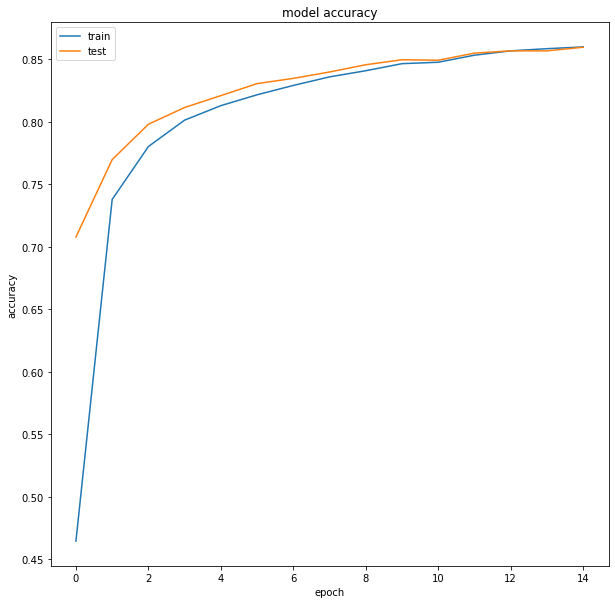

In [10]:
if __name__ == "__main__":
    main()